This notebook details the implementation of a robust synthetic audio detection system, focusing on its resilience against adversarial attacks. We will explore the vulnerabilities of state-of-the-art self-supervised learning (SSL) models (Wav2Vec2, WavLM) and a CNN baseline (ResNet) to various adversarial attacks and subsequently harden these models using adversarial training and other defense mechanisms.

# Library Installation and Imports

In [ ]:
# Install core deep learning and audio processing libraries
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 
!pip install transformers datasets librosa soundfile matplotlib seaborn pandas numpy scikit-learn


# For system utilities (if not already present, e.g., in a non-Colab env)
#!sudo apt-get update && sudo apt-get install -y sox

In [ ]:
!pip install torchattacks

In [24]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from transformers import AutoFeatureExtractor, AutoModelForSequenceClassification, Wav2Vec2ForSequenceClassification, WavLMForSequenceClassification
import librosa

# For adversarial attacks
import torchattacks as ta

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

## Data Loading
We will use the ASVspoof 2019 Logical Access (LA) dataset as our primary benchmark. The dataset structure needs to be navigated to load the audio files and their corresponding labels.

We will focus on the LA (Logical Access) subset, specifically the train, dev, and eval sets. The ASVspoof2019_LA_cm_protocols directory contains txt files that map audio filenames to their labels (bona fide or spoof).

In [ ]:
ASVspoof2019_root
├── LA
│   ├── ASVspoof2019_LA_asv_protocols
│   ├── ASVspoof2019_LA_asv_scores
│   ├── ASVspoof2019_LA_cm_protocols
│   ├── ASVspoof2019_LA_dev
│   ├── ASVspoof2019_LA_eval
│   ├── ASVspoof2019_LA_train
│   └── README.LA.txt
└── PA
    ├── ASVspoof2019_PA_asv_protocols
    ├── ASVspoof2019_PA_asv_scores
    ├── ASVspoof2019_PA_cm_protocols
    ├── ASVspoof2019_PA_dev
    ├── ASVspoof2019_PA_eval
    ├── ASVspoof2019_PA_train
    └── README.PA.txt

In [25]:
# Define the root directory of your ASVspoof 2019 dataset
ASVSPOOF_ROOT_LA = 'ASVspoof2019_root/LA'
# Define the root directory of your ASVspoof 2019 dataset
ASVSPOOF_ROOT_PA = 'ASVspoof2019_root/PA'

In [37]:


# Paths to LA protocol files
TRAIN_PROTOCOL_LA = os.path.join(ASVSPOOF_ROOT_LA, 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt')
DEV_PROTOCOL_LA = os.path.join(ASVSPOOF_ROOT_LA, 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt')
EVAL_PROTOCOL_LA = os.path.join(ASVSPOOF_ROOT_LA, 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt')

# Paths to LA audio directories
TRAIN_AUDIO_DIR_LA = os.path.join(ASVSPOOF_ROOT_LA, 'ASVspoof2019_LA_train/flac')
DEV_AUDIO_DIR_LA = os.path.join(ASVSPOOF_ROOT_LA, 'ASVspoof2019_LA_dev/flac')
EVAL_AUDIO_DIR_LA = os.path.join(ASVSPOOF_ROOT_LA, 'ASVspoof2019_LA_eval/flac')

# Paths to PA protocol files
TRAIN_PROTOCOL_PA = os.path.join(ASVSPOOF_ROOT_PA, 'ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.train.trn.txt')
DEV_PROTOCOL_PA = os.path.join(ASVSPOOF_ROOT_PA, 'ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.dev.trl.txt')
EVAL_PROTOCOL_PA = os.path.join(ASVSPOOF_ROOT_PA, 'ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.eval.trl.txt')

# Paths to PA audio directories
TRAIN_AUDIO_DIR_PA = os.path.join(ASVSPOOF_ROOT_PA, 'ASVspoof2019_PA_train/flac')
DEV_AUDIO_DIR_PA = os.path.join(ASVSPOOF_ROOT_PA, 'ASVspoof2019_PA_dev/flac')
EVAL_AUDIO_DIR_PA = os.path.join(ASVSPOOF_ROOT_PA, 'ASVspoof2019_PA_eval/flac')

def load_protocol_file(protocol_path, audio_dir):
    """
    Loads an ASVspoof protocol file and returns a DataFrame.
    Each row will contain the full path to the audio file and its label.
    """
    data = []
    with open(protocol_path, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            # Assuming the format: speaker_id filename_id - - attack_type label
            # Example: LA_0069 LA_T_1000000 - - A01 bona_fide
            # We need filename_id and label
            filename_id = parts[1]
            label = 1 if parts[-1] == 'bonafide' else 0 # 1 for bonafide, 0 for spoof
            full_path = os.path.join(audio_dir, filename_id + '.flac')
            data.append({'filepath': full_path, 'label': label})
    return pd.DataFrame(data)



In [38]:
# Load dataframes for train, dev, and eval sets
print("Loading LA training data...")
train_df_LA = load_protocol_file(TRAIN_PROTOCOL_LA, TRAIN_AUDIO_DIR_LA)
print(f"Training samples: {len(train_df_LA)}")

Loading LA training data...
Training samples: 25380


In [39]:
train_df_LA.head()

,filepath,label
0,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
1,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
2,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
3,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
4,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1


In [40]:
# Load dataframes for train, dev, and eval sets
print("Loading PA training data...")
train_df_PA = load_protocol_file(TRAIN_PROTOCOL_PA, TRAIN_AUDIO_DIR_PA)
print(f"Training samples: {len(train_df_PA)}")

Loading PA training data...
Training samples: 54000


In [41]:
train_df_PA.head()

,filepath,label
0,ASVspoof2019_root/PA\ASVspoof2019_PA_train/fla...,1
1,ASVspoof2019_root/PA\ASVspoof2019_PA_train/fla...,1
2,ASVspoof2019_root/PA\ASVspoof2019_PA_train/fla...,1
3,ASVspoof2019_root/PA\ASVspoof2019_PA_train/fla...,1
4,ASVspoof2019_root/PA\ASVspoof2019_PA_train/fla...,1


In [30]:
print("Loading LA development data...")
dev_df_LA = load_protocol_file(DEV_PROTOCOL_LA, DEV_AUDIO_DIR_LA)
print(f"Development samples: {len(dev_df_LA)}")

Loading LA development data...
Development samples: 24844


In [31]:
dev_df_LA.head()

,filepath,label
0,ASVspoof2019_root/LA\ASVspoof2019_LA_dev/flac\...,1
1,ASVspoof2019_root/LA\ASVspoof2019_LA_dev/flac\...,1
2,ASVspoof2019_root/LA\ASVspoof2019_LA_dev/flac\...,1
3,ASVspoof2019_root/LA\ASVspoof2019_LA_dev/flac\...,1
4,ASVspoof2019_root/LA\ASVspoof2019_LA_dev/flac\...,1


In [42]:
print("Loading PA development data...")
dev_df_PA = load_protocol_file(DEV_PROTOCOL_PA, DEV_AUDIO_DIR_PA)
print(f"Development samples: {len(dev_df_PA)}")

Loading PA development data...
Development samples: 29700


In [43]:
dev_df_PA.head()

,filepath,label
0,ASVspoof2019_root/PA\ASVspoof2019_PA_dev/flac\...,1
1,ASVspoof2019_root/PA\ASVspoof2019_PA_dev/flac\...,1
2,ASVspoof2019_root/PA\ASVspoof2019_PA_dev/flac\...,1
3,ASVspoof2019_root/PA\ASVspoof2019_PA_dev/flac\...,1
4,ASVspoof2019_root/PA\ASVspoof2019_PA_dev/flac\...,1


In [33]:
print("Loading LA evaluation data...")
eval_df_LA = load_protocol_file(EVAL_PROTOCOL_LA, EVAL_AUDIO_DIR_LA)
print(f"Evaluation samples: {len(eval_df_LA)}")

Loading LA evaluation data...
Evaluation samples: 71237


In [35]:
eval_df_LA.head()

,filepath,label
0,ASVspoof2019_root/LA\ASVspoof2019_LA_eval/flac...,0
1,ASVspoof2019_root/LA\ASVspoof2019_LA_eval/flac...,0
2,ASVspoof2019_root/LA\ASVspoof2019_LA_eval/flac...,0
3,ASVspoof2019_root/LA\ASVspoof2019_LA_eval/flac...,0
4,ASVspoof2019_root/LA\ASVspoof2019_LA_eval/flac...,0


In [44]:
print("Loading PA evaluation data...")
eval_df_PA = load_protocol_file(EVAL_PROTOCOL_PA, EVAL_AUDIO_DIR_PA)
print(f"Evaluation samples: {len(eval_df_PA)}")

Loading PA evaluation data...
Evaluation samples: 134730


In [45]:
eval_df_PA.head()

,filepath,label
0,ASVspoof2019_root/PA\ASVspoof2019_PA_eval/flac...,1
1,ASVspoof2019_root/PA\ASVspoof2019_PA_eval/flac...,0
2,ASVspoof2019_root/PA\ASVspoof2019_PA_eval/flac...,0
3,ASVspoof2019_root/PA\ASVspoof2019_PA_eval/flac...,0
4,ASVspoof2019_root/PA\ASVspoof2019_PA_eval/flac...,0


In [47]:

# Concatenate all data for initial exploration and consistent preprocessing
full_df = pd.concat([train_df_LA, dev_df_LA, eval_df_LA,train_df_PA, dev_df_PA, eval_df_PA], ignore_index=True)
print(f"Total samples loaded: {len(full_df)}")

# Display a sample of the dataframe
print("\nSample of loaded data:")
full_df.head()

Total samples loaded: 339891

Sample of loaded data:


,filepath,label
0,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
1,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
2,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
3,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1
4,ASVspoof2019_root/LA\ASVspoof2019_LA_train/fla...,1


## Data Exploration
Understanding the dataset is crucial. We'll look at the distribution of bona fide vs. spoof samples, audio lengths, and visualize some spectrograms.

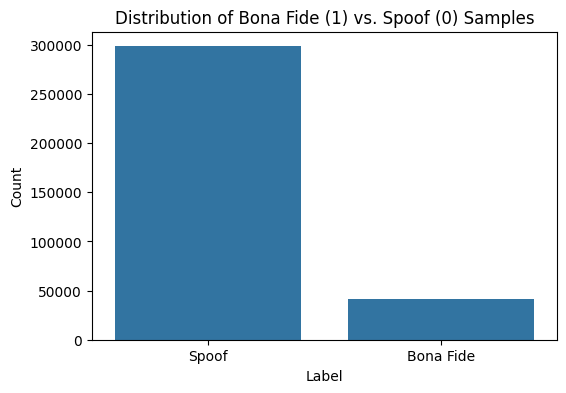

label
0    298518
1     41373
Name: count, dtype: int64

Calculating audio lengths (this might take a few minutes)...


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [48]:
# Label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=full_df)
plt.title('Distribution of Bona Fide (1) vs. Spoof (0) Samples')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Spoof', 'Bona Fide'])
plt.show()
print(full_df['label'].value_counts())

# Audio length distribution
audio_lengths = []
sample_rate = 16000 # Standard sampling rate for ASVspoof 2019

# This can be time-consuming for large datasets, consider sampling
print("\nCalculating audio lengths (this might take a few minutes)...")
for i, row in tqdm(full_df.sample(min(10000, len(full_df))).iterrows(), total=min(10000, len(full_df))): # Sample for speed
    try:
        y, sr = torchaudio.load(row['filepath'])
        audio_lengths.append(y.shape[1] / sr)
    except Exception as e:
        print(f"Error loading {row['filepath']}: {e}")
        audio_lengths.append(0) # Append 0 or NaN for failed loads

audio_lengths = np.array(audio_lengths)
audio_lengths = audio_lengths[audio_lengths > 0] # Filter out failed loads

plt.figure(figsize=(10, 6))
sns.histplot(audio_lengths, bins=50, kde=True)
plt.title('Distribution of Audio File Durations (seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

print(f"Min audio length: {np.min(audio_lengths):.2f}s")
print(f"Max audio length: {np.max(audio_lengths):.2f}s")
print(f"Mean audio length: {np.mean(audio_lengths):.2f}s")
print(f"Median audio length: {np.median(audio_lengths):.2f}s")

# Visualize a few spectrograms
print("\nVisualizing Spectrograms:")
def plot_spectrogram(filepath, title):
    try:
        waveform, sample_rate = torchaudio.load(filepath)
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Compute Mel spectrogram
        # n_mels=80 and n_fft=400 (for 25ms window at 16kHz) are common for speech
        mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=400,
            hop_length=160, # 10ms hop
            n_mels=80
        )
        mel_spectrogram = mel_spectrogram_transform(waveform)
        mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

        plt.figure(figsize=(12, 4))
        plt.imshow(mel_spectrogram_db.squeeze().log().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.xlabel('Time Frame')
        plt.ylabel('Mel Filter Bank')
        plt.show()
    except Exception as e:
        print(f"Could not plot spectrogram for {filepath}: {e}")

# Get a random bona fide and a random spoof sample
bona_fide_sample = full_df[full_df['label'] == 1].sample(1)['filepath'].iloc[0]
spoof_sample = full_df[full_df['label'] == 0].sample(1)['filepath'].iloc[0]

plot_spectrogram(bona_fide_sample, 'Bona Fide Audio Spectrogram')
plot_spectrogram(spoof_sample, 'Spoof Audio Spectrogram')

## Data Preprocessing
Based on the proposal, audio files need to be standardized (mono, 16-bit PCM WAV, 16kHz sampling rate) and segmented into fixed-length chunks. We'll implement a custom PyTorch Dataset for this.

In [ ]:
TARGET_SAMPLE_RATE = 16000
CHUNK_LENGTH_SEC = 4 # As specified in the proposal
MAX_AUDIO_LENGTH = CHUNK_LENGTH_SEC * TARGET_SAMPLE_RATE # Max samples per chunk

class AudioSpoofDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, max_length=MAX_AUDIO_LENGTH, sample_rate=TARGET_SAMPLE_RATE):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.max_length = max_length
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filepath = self.dataframe.iloc[idx]['filepath']
        label = self.dataframe.iloc[idx]['label']

        try:
            waveform, sr = torchaudio.load(filepath)

            # Resample if necessary
            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
                waveform = resampler(waveform)

            # Convert to mono
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Pad or truncate to max_length
            if waveform.shape[1] < self.max_length:
                padding = self.max_length - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            else:
                waveform = waveform[:, :self.max_length] # Take the first N samples

            # Feature extraction (e.g., for Wav2Vec2/WavLM, this means batching the raw waveform)
            # The feature_extractor from transformers handles normalization
            inputs = self.feature_extractor(
                waveform.squeeze(0).numpy(), # Squeeze to 1D numpy array for feature_extractor
                sampling_rate=self.sample_rate,
                return_tensors="pt",
                padding="max_length", # ensure consistent length for batching
                max_length=self.max_length
            )

            # inputs will contain 'input_values' (raw waveform converted to features for the model)
            # and potentially 'attention_mask'
            return {'input_values': inputs['input_values'].squeeze(0), 'labels': torch.tensor(label, dtype=torch.long)}

        except Exception as e:
            print(f"Error processing {filepath}: {e}. Skipping this sample.")
            # Return a placeholder or raise an error depending on desired behavior
            # For simplicity, returning a dummy tensor here, but in a real scenario, you might filter these out
            return {'input_values': torch.zeros(self.max_length), 'labels': torch.tensor(-1, dtype=torch.long)} # Dummy invalid
            
# Instantiate a feature extractor (e.g., for Wav2Vec2)
# The specific feature extractor depends on the model. For Wav2Vec2/WavLM, it mainly handles
# resampling and tokenization if needed, but often just converts to the correct format.
# We'll use a generic one first and specific ones when defining models.
# For Wav2Vec2, input is typically raw audio, which `AutoFeatureExtractor` handles.
feature_extractor_w2v2 = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Create datasets and dataloaders
# Filter out any samples that might have failed loading or processing
train_df_filtered = train_df[train_df['filepath'].apply(os.path.exists)]
dev_df_filtered = dev_df[dev_df['filepath'].apply(os.path.exists)]
eval_df_filtered = eval_df[eval_df['filepath'].apply(os.path.exists)]

train_dataset = AudioSpoofDataset(train_df_filtered, feature_extractor_w2v2)
dev_dataset = AudioSpoofDataset(dev_df_filtered, feature_extractor_w2v2)
eval_dataset = AudioSpoofDataset(eval_df_filtered, feature_extractor_w2v2)

BATCH_SIZE = 8 # Adjust based on your GPU memory

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of development batches: {len(dev_dataloader)}")
print(f"Number of evaluation batches: {len(eval_dataloader)}")

# Test a single batch
for batch in train_dataloader:
    print(f"Input values shape: {batch['input_values'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")
    break

## Feature Engineering (for ResNet/CNN Baseline)
For the SSL models (Wav2Vec2, WavLM), the raw waveform is the input, and the model itself performs feature extraction. For the ResNet/CNN baseline, we need to explicitly compute Mel-spectrograms. This will be integrated into a separate Dataset class.

In [ ]:
class MelSpectrogramSpoofDataset(Dataset):
    def __init__(self, dataframe, n_mels=80, n_fft=400, hop_length=160, max_length=MAX_AUDIO_LENGTH, sample_rate=TARGET_SAMPLE_RATE):
        self.dataframe = dataframe
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_length = max_length
        self.sample_rate = sample_rate
        
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )
        self.amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filepath = self.dataframe.iloc[idx]['filepath']
        label = self.dataframe.iloc[idx]['label']

        try:
            waveform, sr = torchaudio.load(filepath)

            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            if waveform.shape[1] < self.max_length:
                padding = self.max_length - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            else:
                waveform = waveform[:, :self.max_length]

            mel_spectrogram = self.mel_spectrogram_transform(waveform)
            mel_spectrogram_db = self.amplitude_to_db_transform(mel_spectrogram)
            
            # Ensure the spectrogram has a channel dimension (e.g., [1, n_mels, time_frames]) for CNN input
            if mel_spectrogram_db.ndim == 2:
                mel_spectrogram_db = mel_spectrogram_db.unsqueeze(0) # Add channel dimension

            return {'input_values': mel_spectrogram_db, 'labels': torch.tensor(label, dtype=torch.long)}

        except Exception as e:
            print(f"Error processing {filepath}: {e}. Skipping this sample.")
            return {'input_values': torch.zeros(1, self.n_mels, self.max_length // self.hop_length + 1), 'labels': torch.tensor(-1, dtype=torch.long)}

# Create datasets and dataloaders for ResNet
train_resnet_dataset = MelSpectrogramSpoofDataset(train_df_filtered)
dev_resnet_dataset = MelSpectrogramSpoofDataset(dev_df_filtered)
eval_resnet_dataset = MelSpectrogramSpoofDataset(eval_df_filtered)

train_resnet_dataloader = DataLoader(train_resnet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_resnet_dataloader = DataLoader(dev_resnet_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
eval_resnet_dataloader = DataLoader(eval_resnet_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"\nNumber of ResNet training batches: {len(train_resnet_dataloader)}")
for batch in train_resnet_dataloader:
    print(f"ResNet Input values shape: {batch['input_values'].shape}") # Should be [BATCH_SIZE, 1, n_mels, time_frames]
    print(f"ResNet Labels shape: {batch['labels'].shape}")
    break

## Models
We will implement three models as specified in the proposal:

- Wav2Vec2 (SSL model)
- WavLM (SSL model)
- ResNet-based CNN (non-SSL baseline)
  
For Wav2Vec2 and WavLM, we will leverage the transformers library, adding a classification head. For ResNet, we'll define a custom CNN architecture.

In [ ]:
# --- Base Class for Training & Evaluation ---
class BaseModelTrainer:
    def __init__(self, model, dataloaders, optimizer, criterion, device):
        self.model = model.to(device)
        self.train_loader, self.dev_loader, self.eval_loader = dataloaders
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {'train_loss': [], 'dev_loss': [], 'dev_eer': [], 'dev_asr': []}

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for batch in tqdm(self.train_loader, desc="Training"):
            inputs = batch['input_values'].to(self.device)
            labels = batch['labels'].to(self.device)

            self.optimizer.zero_grad()
            
            # Models from transformers return an output object with 'logits'
            if isinstance(self.model, (Wav2Vec2ForSequenceClassification, WavLMForSequenceClassification)):
                outputs = self.model(inputs, labels=labels)
                loss = outputs.loss
            else: # Custom CNN/ResNet
                logits = self.model(inputs)
                loss = self.criterion(logits, labels)
            
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def evaluate(self, dataloader, attack=None, description="Evaluation"):
        self.model.eval()
        total_loss = 0
        all_labels = []
        all_preds = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=description):
                inputs = batch['input_values'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Apply adversarial attack if provided
                if attack:
                    inputs_adv = attack(inputs, labels) # Attack might need labels
                    # Ensure the adversarial attack does not modify original inputs outside this scope
                    inputs = inputs_adv.detach() 

                if isinstance(self.model, (Wav2Vec2ForSequenceClassification, WavLMForSequenceClassification)):
                    outputs = self.model(inputs)
                    logits = outputs.logits
                else:
                    logits = self.model(inputs)

                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                probs = torch.softmax(logits, dim=-1)
                preds = torch.argmax(probs, dim=-1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy()) # Probability of being bona fide

        avg_loss = total_loss / len(dataloader)
        
        # Calculate EER
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        eer_threshold = thresholds[np.argmin(np.abs(fpr - (1 - tpr)))]
        eer = fpr[np.argmin(np.abs(fpr - (1 - tpr)))] # EER is FPR at threshold where FAR=FRR

        # Calculate ASR (Attack Success Rate) - relevant for adversarial evaluation
        # For spoofing detection, ASR is when a SPOOF sample is misclassified as BONA FIDE (label 1)
        # So, we only consider actual spoof samples (label 0)
        spoof_indices = [i for i, label in enumerate(all_labels) if label == 0]
        if len(spoof_indices) > 0:
            spoof_labels = [all_labels[i] for i in spoof_indices]
            spoof_preds = [all_preds[i] for i in spoof_indices]
            # ASR: spoof (0) classified as bona_fide (1)
            asr = np.sum(np.array(spoof_preds) == 1) / len(spoof_preds)
        else:
            asr = 0.0 # No spoof samples to attack

        # Other metrics
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)

        print(f"  {description} Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, EER: {eer:.4f}, ASR: {asr:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        return avg_loss, eer, asr, accuracy, f1, precision, recall

    def fit(self, num_epochs, adv_attack_trainer=None):
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            if adv_attack_trainer: # Use adversarial training loop
                train_loss = adv_attack_trainer.train_epoch_adv()
            else: # Standard training
                train_loss = self.train_epoch()
            
            dev_loss, dev_eer, dev_asr, _, _, _, _ = self.evaluate(self.dev_loader, description="Development")
            
            self.history['train_loss'].append(train_loss)
            self.history['dev_loss'].append(dev_loss)
            self.history['dev_eer'].append(dev_eer)
            self.history['dev_asr'].append(dev_asr) # This ASR would be on clean dev set for baseline

            print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Dev Loss: {dev_loss:.4f}, Dev EER: {dev_eer:.4f}")
            
            # Simple early stopping (can be improved)
            # if len(self.history['dev_loss']) > 1 and dev_loss > self.history['dev_loss'][-2]:
            #     print("Development loss increased, stopping early.")
            #     break
        print("Training complete.")

# --- Adversarial Training Wrapper ---
class AdversarialTrainer(BaseModelTrainer):
    def __init__(self, model, dataloaders, optimizer, criterion, device, attack_class, attack_params):
        super().__init__(model, dataloaders, optimizer, criterion, device)
        self.attack_class = attack_class
        self.attack_params = attack_params
        
    def train_epoch_adv(self):
        self.model.train()
        total_loss = 0
        
        # Instantiate the attack for the current model within the training loop
        # This is crucial for white-box attacks where the attack needs the model itself
        if isinstance(self.model, (Wav2Vec2ForSequenceClassification, WavLMForSequenceClassification)):
            # For HuggingFace models, the attack will directly interact with the model's forward pass
            pass # Attack is instantiated per batch inside the loop
        else: # For custom ResNet, attack needs the module
            self.attack = self.attack_class(self.model, **self.attack_params)

        for batch in tqdm(self.train_loader, desc="Adversarial Training"):
            inputs = batch['input_values'].to(self.device)
            labels = batch['labels'].to(self.device)

            self.optimizer.zero_grad()
            
            # Generate adversarial examples on-the-fly
            if isinstance(self.model, (Wav2Vec2ForSequenceClassification, WavLMForSequenceClassification)):
                # For transformers models, attacks might need custom wrappers or to be applied to raw inputs
                # For simplicity here, we assume attack_class directly takes model, inputs, labels
                # A more robust implementation might require a custom attack wrapper for HuggingFace models
                attack_instance = self.attack_class(self.model, **self.attack_params)
                inputs_adv = attack_instance(inputs, labels)
            else:
                inputs_adv = self.attack(inputs, labels) # Use pre-instantiated attack for custom models

            # Train on adversarial examples
            if isinstance(self.model, (Wav2Vec2ForSequenceClassification, WavLMForSequenceClassification)):
                outputs = self.model(inputs_adv, labels=labels)
                loss = outputs.loss
            else:
                logits = self.model(inputs_adv)
                loss = self.criterion(logits, labels)
            
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)


# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Wav2Vec2 Model ---
print("\nInitializing Wav2Vec2 model...")
# Using a pre-trained base model and adding a classification head (num_labels=2 for binary)
model_w2v2 = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    ignore_mismatched_sizes=True # Ignore warnings if head is replaced
)
# Ensure the feature extractor used for the dataset matches the model's expectations
feature_extractor_w2v2 = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_dataset_w2v2 = AudioSpoofDataset(train_df_filtered, feature_extractor_w2v2)
dev_dataset_w2v2 = AudioSpoofDataset(dev_df_filtered, feature_extractor_w2v2)
eval_dataset_w2v2 = AudioSpoofDataset(eval_df_filtered, feature_extractor_w2v2)
train_dataloader_w2v2 = DataLoader(train_dataset_w2v2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_dataloader_w2v2 = DataLoader(dev_dataset_w2v2, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
eval_dataloader_w2v2 = DataLoader(eval_dataset_w2v2, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


optimizer_w2v2 = torch.optim.AdamW(model_w2v2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# --- 2. WavLM Model ---
print("\nInitializing WavLM model...")
model_wavlm = WavLMForSequenceClassification.from_pretrained(
    "microsoft/wavlm-base",
    num_labels=2,
    ignore_mismatched_sizes=True
)
feature_extractor_wavlm = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base")
train_dataset_wavlm = AudioSpoofDataset(train_df_filtered, feature_extractor_wavlm)
dev_dataset_wavlm = AudioSpoofDataset(dev_df_filtered, feature_extractor_wavlm)
eval_dataset_wavlm = AudioSpoofDataset(eval_df_filtered, feature_extractor_wavlm)
train_dataloader_wavlm = DataLoader(train_dataset_wavlm, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_dataloader_wavlm = DataLoader(dev_dataset_wavlm, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
eval_dataloader_wavlm = DataLoader(eval_dataset_wavlm, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

optimizer_wavlm = torch.optim.AdamW(model_wavlm.parameters(), lr=1e-5)

# --- 3. ResNet-based CNN ---
print("\nInitializing ResNet-